In [1]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.examples.tutorials.mnist import input_data
from skimage import transform
import numpy as np
import torch.optim as optim
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

mnist = input_data.read_data_sets("MNIST_data", one_hot=False)
batch_size = 250   # Number of samples in each batch
epoch_num = 10      # Number of epochs to train the network
lr = 0.0001        # Learning rate
disp_freq = 20


def next_batch(train=True):
    # Reads the next batch of MNIST images and labels and returns them
    if train:
        batch_img, batch_label = mnist.train.next_batch(batch_size)
    else:
        batch_img, batch_label = mnist.test.next_batch(batch_size)

    # reshape the sample to a batch of images in pytorch order (batch, channels, height, width)
    batch_img = batch_img.reshape((-1, 1, 28, 28))

    # resize the images
    resized_imgs = np.zeros((batch_img.shape[0], 1, 32, 32))
    for i in range(batch_img.shape[0]):
        resized_imgs[i, 0, ...] = transform.resize(batch_img[i, 0,...], (32, 32))

    batch_label = torch.from_numpy(batch_label).long()  # convert the numpy array into torch tensor
    batch_label = Variable(batch_label)        # create a torch variable 

    resized_imgs = torch.from_numpy(resized_imgs).float()     # convert the numpy array into torch tensor
    resized_imgs = Variable(resized_imgs)            # create a torch variable 
    return resized_imgs, batch_label


class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        # conv layers: (in_channel size, out_channels size, kernel_size, stride, padding)
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 16, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(16, 8, 5, stride=1, padding=2)

        # max pooling (kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)

        # fully conected layers:
        self.layer1 = nn.Linear(4*4*8, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_classes)

    def forward(self, x, training=True):
        # the autoencoder has 3 con layers and 3 deconv layers (transposed conv). All layers but the last have ReLu
        # activation function
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 4 * 4 * 8)
        x = F.relu(self.layer1(x))
        x = F.dropout(x, 0.5, training=training)
        x = F.relu(self.layer2(x))
        x = F.dropout(x, 0.5, training=training)
        x = self.layer3(x)
        return x

    def predict(self, x):
        # a function to predict the labels of a batch of inputs
        x = F.softmax(self.forward(x, training=False))
        return x

    def accuracy(self, x, y):
        # a function to calculate the accuracy of label prediction for a batch of inputs
        #   x: a batch of inputs
        #   y: the true labels associated with x
        prediction = self.predict(x)
        maxs, indices = torch.max(prediction, 1)
        acc = 100 * torch.sum(torch.eq(indices.float(), y.float()).float())/y.size()[0]
        return acc.data

# define the CNN 
cnn = CNN(10)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

# define the loss (criterion) and create an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr)

print(' ')
print("__________Training__________________")

xArray = []
yLoss = []
for ep in range(epoch_num):  # epochs loop
    for batch_n in range(batch_per_ep):  # batches loop
        
        features, labels = next_batch()

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        # output = cnn(features)
        output = cnn.predict(features)
        loss = criterion(output, labels)    # calculate the los
    
        # Backward pass and updates
        loss.backward()                     # calculate the gradients (backpropagation)
        optimizer.step()                    # update the weights
       
        if batch_n % disp_freq == 0:
            print('epoch: {} - batch: {}/{} '.format(ep, batch_n, batch_per_ep))
    xArray.append(ep)
    yLoss.append(loss.data)
    print('loss: ', loss.data)
    print('__________________________________')


# test the accuracy on a batch of test data
features, labels = next_batch(train=False)
print("Result")
print('Test accuracy: ', cnn.accuracy(features, labels))
print('loss: ', loss.data)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
 
__________Training__________________


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0 - batch: 0/220 
epoch: 0 - batch: 20/220 
epoch: 0 - batch: 40/220 
epoch: 0 - batch: 60/220 
epoch: 0 - batch: 80/220 
epoch: 0 - batch: 100/220 
epoch: 0 - batch: 120/220 
epoch: 0 - batch: 140/220 
epoch: 0 - batch: 160/220 
epoch: 0 - batch: 180/220 
epoch: 0 - batch: 200/220 
loss:  tensor(1.8770)
__________________________________
epoch: 1 - batch: 0/220 
epoch: 1 - batch: 20/220 
epoch: 1 - batch: 40/220 
epoch: 1 - batch: 60/220 
epoch: 1 - batch: 80/220 
epoch: 1 - batch: 100/220 
epoch: 1 - batch: 120/220 
epoch: 1 - batch: 140/220 
epoch: 1 - batch: 160/220 
epoch: 1 - batch: 180/220 
epoch: 1 - batch: 200/220 
loss:  tensor(1.7096)
__________________________________
epoch: 2 - batch: 0/220 
epoch: 2 - batch: 20/220 
epoch: 2 - batch: 40/220 
epoch: 2 - batch: 60/220 
epoch: 2 - batch: 80/220 
epoch: 2 - batch: 100/220 
epoch: 2 - batch: 120/220 
epoch: 2 - batch: 140/220 
epoch: 2 - batch: 160/220 
epoch: 2 - batch: 180/220 
epoch: 2 - batch: 200/220 
loss:  tensor

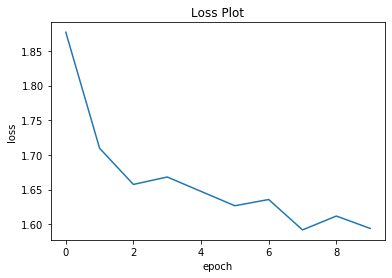

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#Loss Plot

# plotting the points  
plt.plot(xArray, yLoss) 
  
# naming the x axis 
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('loss') 
  
# giving a title to my graph 
plt.title('Loss Plot') 
  
# function to show the plot 
plt.show() 